# 1. DETECÇÃO DE FRAUDES COM NAIVE BAYES

# === IMPORTAÇÃO DE BIBLIOTECAS ===

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. CARGA DO DATASET ===

In [2]:
df = pd.read_csv("creditcard.csv")
print("Total de transações:", len(df))
print("Total de fraudes:", df['Class'].sum())

Total de transações: 284807
Total de fraudes: 492


# === 2. PRÉ-PROCESSAMENTO ===

In [3]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceamento com SMOTE

In [5]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

## Validação Cruzada

In [6]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {}
print("\n=== Validação Cruzada (média das métricas) ===")
for metric_name, scorer in scoring.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer, n_jobs=-1)
    scores[metric_name] = cv_scores.mean()
    print(f"{metric_name.upper()}: {cv_scores.mean():.4f}")


=== Validação Cruzada (média das métricas) ===
ACCURACY: 0.9771
PRECISION: 0.0614
RECALL: 0.8557
F1: 0.1146
ROC_AUC: 0.9580


# Divisão treino/teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# === 3. MODELO NAIVE BAYES ===

In [8]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
y_proba = nb_model.predict_proba(X_test)[:, 1]

# === 4. AVALIAÇÃO ===

In [9]:
print("\n=== MATRIZ DE CONFUSÃO ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\n=== ROC-AUC: {auc:.4f} ===")


=== MATRIZ DE CONFUSÃO ===
[[56457   407]
 [   33    65]]

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.66      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.83      0.61     56962
weighted avg       1.00      0.99      0.99     56962


=== ROC-AUC: 0.9677 ===


# Curva ROC

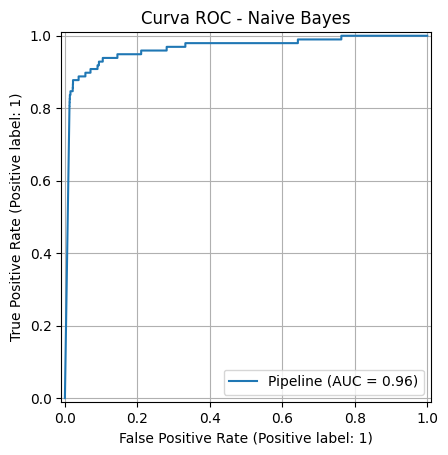

In [13]:
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("Curva ROC - Naive Bayes")
plt.grid(True)
plt.show()

# Heatmap da matriz de confusão

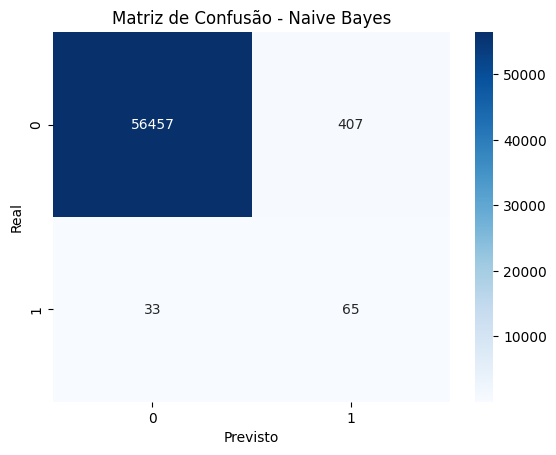

In [14]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Naive Bayes")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()
